# **Assignment 2 : Topic Modelling**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing Packages**

In [ ]:
!pip install pandas --upgrade
!pip install matplotlib --upgrade

In [ ]:
pip install pyLDAvis

In [ ]:
pip install openpyxl==3.0.0

In [ ]:
pip install sweetviz

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint


#Report
import sweetviz as sv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### **Preparing Stopwords**

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')
#python3 -m spacy download en

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### **Importing Park hotel reviews data**

In [ ]:
# Import Dataset
df = pd.read_excel('/content/drive/MyDrive/Text_Analytics/Assignment 2/tajMahalTower_mumbai.xlsx')
df.head()

revTitle  ...                                             review
0  Taj is no more at the level of Taj (as I have ...  ...     Taj should relook and compare yourself with...
1                          Caring with small details  ...     Every time I stay here, I feel welcomes and...
2                               tajness was missing!  ...    Custom porridge was provided to the baby.  B...
3         Could have been much better esp. the food.  ...    allocated the 2nd room 1006 - which was not ...
4                                         ⭐️⭐️⭐️⭐️⭐️  ...     Amazing experience. If you are visiting mum...

[5 rows x 5 columns]

### **EDA**

In [ ]:
data = pd.DataFrame(df)
my_report = sv.analyze(data)
my_report.show_html() 

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
import plotly.express as px

fig1 = px.histogram(df, x="rating",color="rating")
fig2 = px.histogram(df, x="date",y="rating",color="rating") 
fig1.show()
fig2.show()

### **Text Cleansing**

In [ ]:
# Replace email address with 'emailaddress'
df['review'] = df['review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['review'] = df['review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['review'] = df['review'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['review'] = df['review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['review'] = df['review'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['review'] = df['review'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['review'] = df['review'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['review'] = df['review'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['review'] = df['review'].str.lower()

# remove non alphabets with whitespace
df['review'] = df['review'].str.replace(r'[^a-zA-Z]', ' ')

In [ ]:
df.review.head()

0     taj should relook and compare yourself with y...
1     every time i stay here i feel welcomes and lo...
2     custom porridge was provided to the baby brea...
3     allocated the numbernd room number which was ...
4     amazing experience if you are visiting mumbai...
Name: review, dtype: object

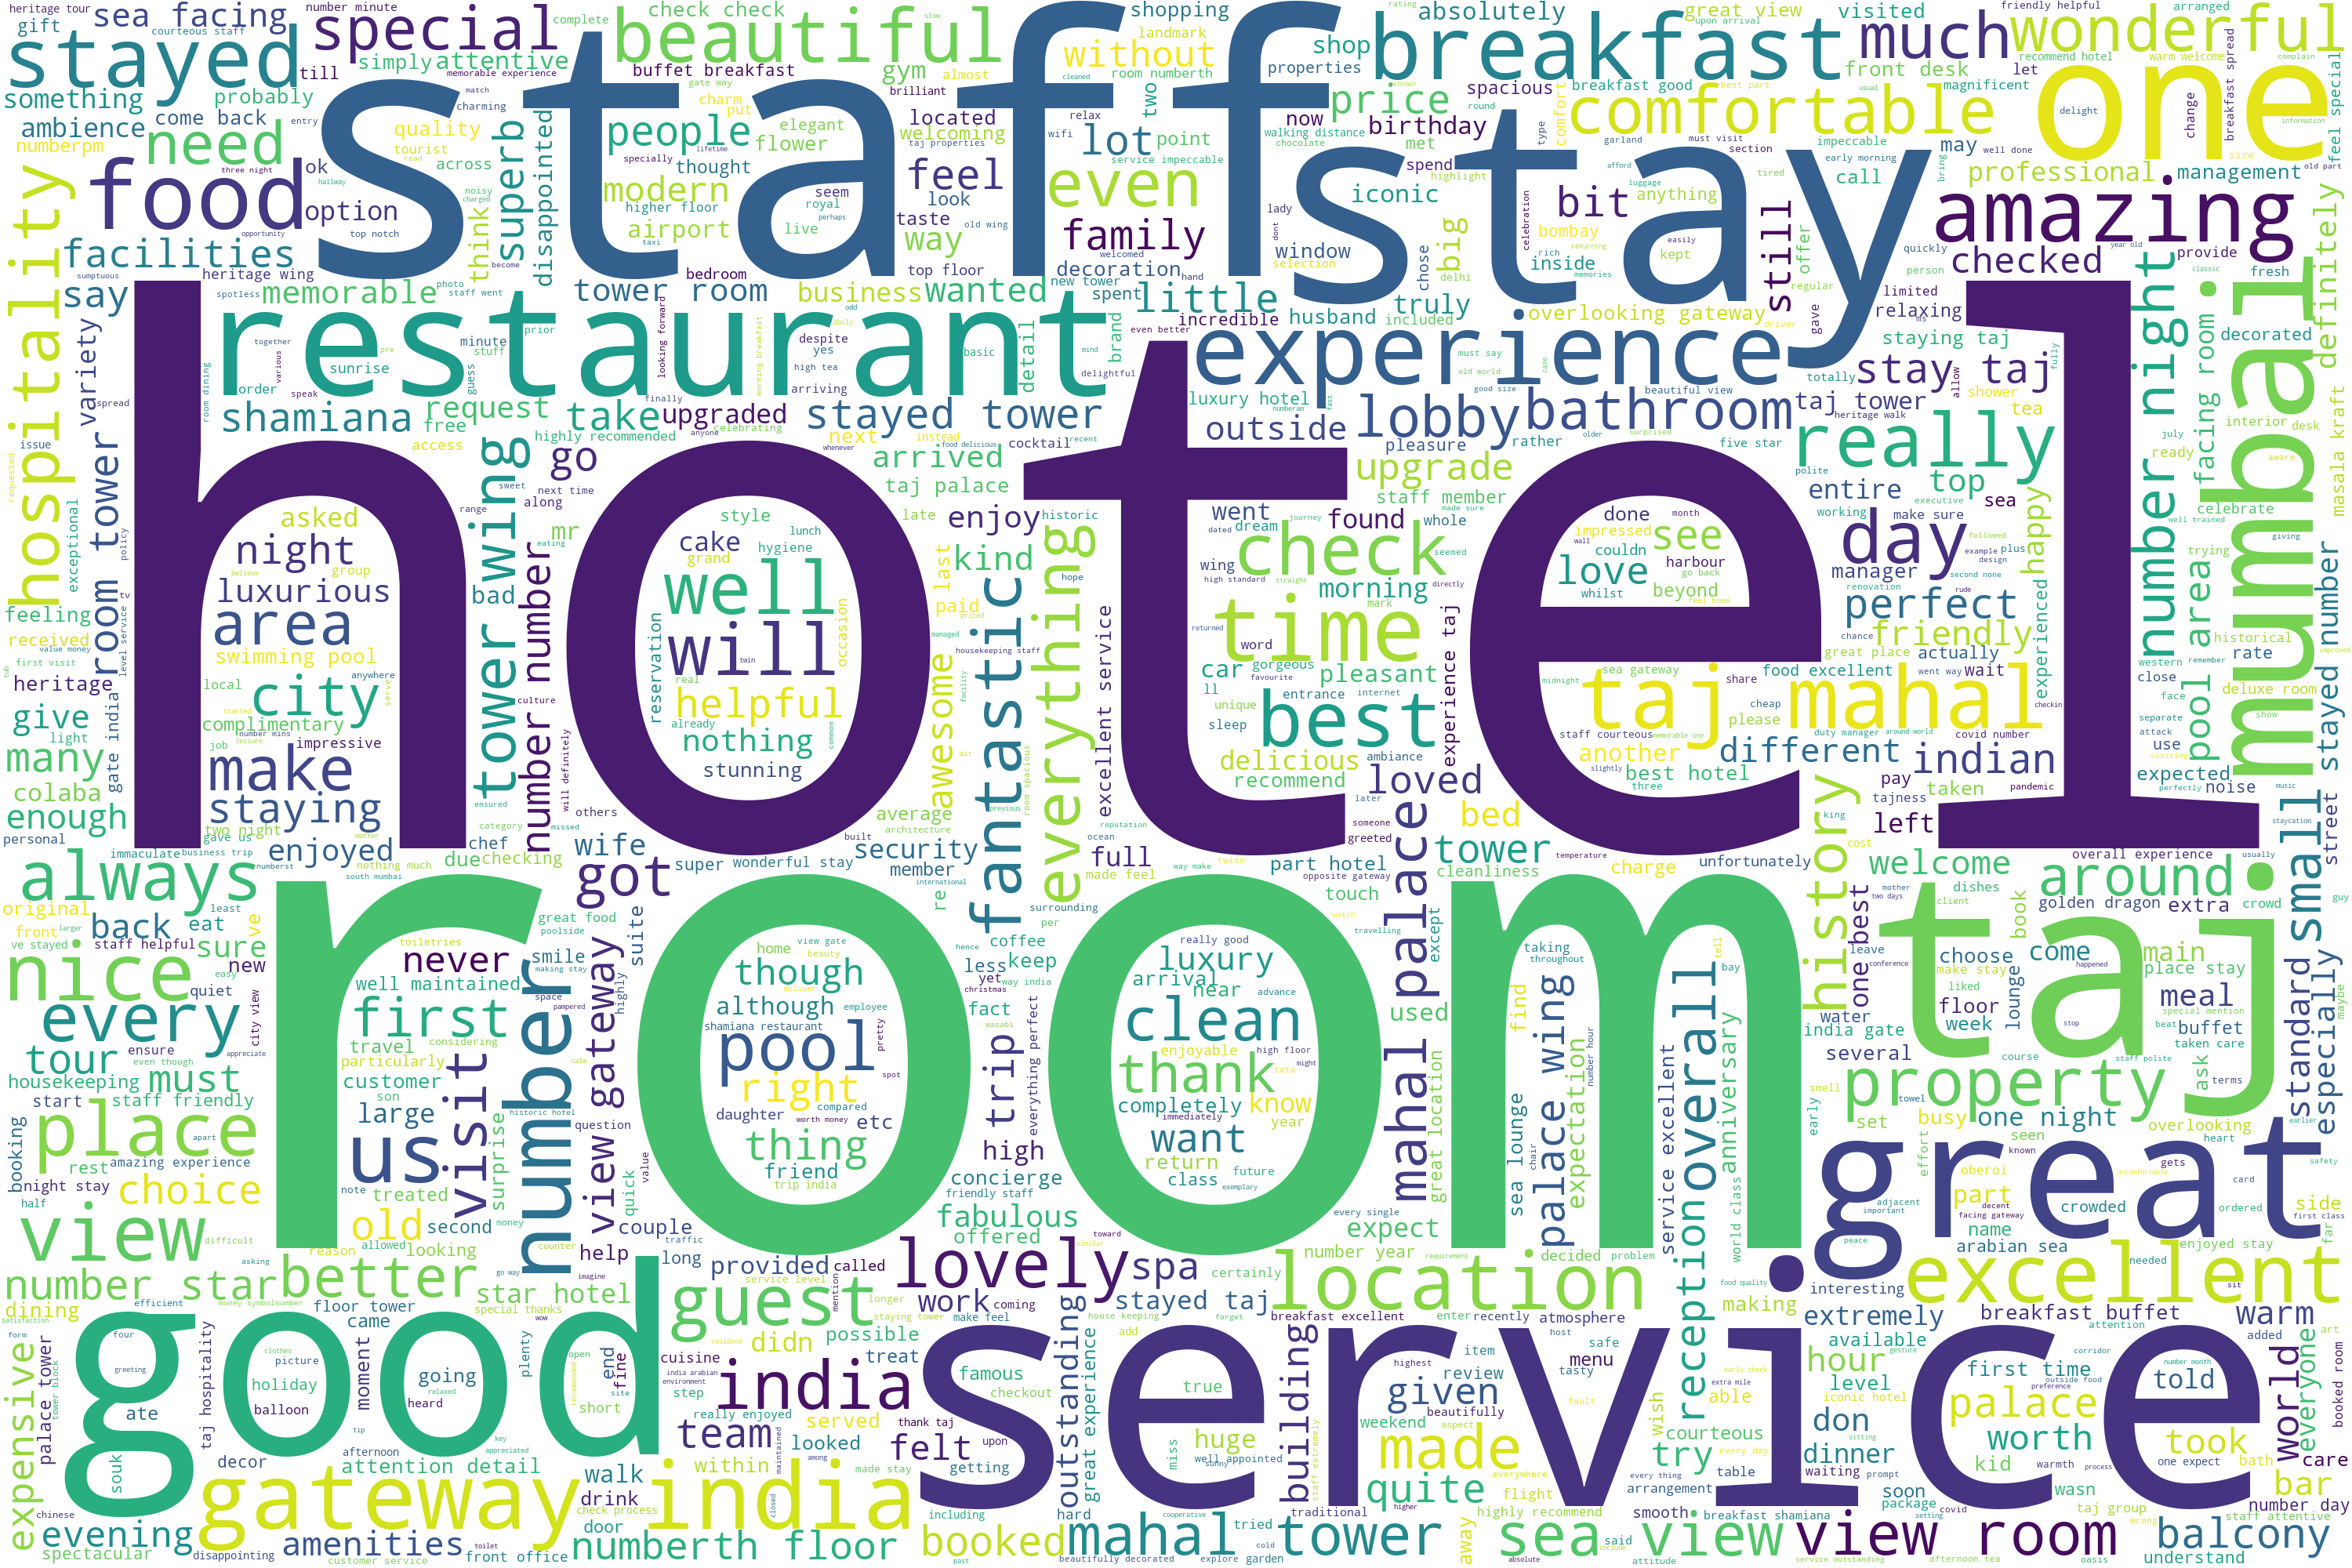

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['review'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=25, width = 3000, height = 2000,contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### **Tokenize words and Clean-up text**

The sentences look better now, but we tokenize each sentence into a list of words, removing punctuations and unneccessary characters altogether.

Gensim's `simple_preprocess()` is being used for this. Additionally I have set `deacc=True` to remove the punctuations.

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['review']))
print(data_words[:1])


[['taj', 'should', 'relook', 'and', 'compare', 'yourself', 'with', 'your', 'own', 'history', 'taj', 'is', 'was', 'ultimate', 'gold', 'standard', 'of', 'hospitality', 'and', 'hotel', 'but', 'our', 'experience', 'was', 'disheartening', 'to', 'see', 'taj', 'loosing', 'its', 'sheen', 'am', 'not', 'saying', 'it', 'was', 'bad', 'for', 'number', 'star', 'hotel', 'it', 'was', 'bad', 'for', 'taj', 'which', 'was', 'top', 'most', 'level', 'in', 'the', 'number', 'star', 'hotel', 'now', 'it', 'is', 'barely', 'making', 'into', 'number', 'star', 'level', 'as', 'per', 'our', 'experience']]


### **Creating Bigram and Trigram Models**

Gensim's `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



['taj', 'should', 'relook', 'and', 'compare', 'yourself', 'with', 'your', 'own', 'history', 'taj', 'is', 'was', 'ultimate', 'gold', 'standard', 'of', 'hospitality', 'and', 'hotel', 'but', 'our', 'experience', 'was', 'disheartening', 'to', 'see', 'taj', 'loosing', 'its', 'sheen', 'am', 'not', 'saying', 'it', 'was', 'bad', 'for', 'number', 'star', 'hotel', 'it', 'was', 'bad', 'for', 'taj', 'which', 'was', 'top', 'most', 'level', 'in', 'the', 'number', 'star', 'hotel', 'now', 'it', 'is', 'barely', 'making', 'into', 'number', 'star', 'level', 'as', 'per', 'our', 'experience']


### **Remove Stopwords, Make Bigrams and Lemmatize**

In [ ]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [ ]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['compare', 'history', 'ultimate', 'gold', 'standard', 'hospitality', 'hotel', 'experience', 'dishearten', 'see', 'loose', 'sheen', 'say', 'bad', 'number', 'star', 'hotel', 'bad', 'top', 'level', 'number', 'star', 'hotel', 'barely', 'make', 'number', 'star', 'level', 'experience']]


In [ ]:
wordlist = ' '.join(map(str, data_lemmatized))

In [ ]:
wordlist  = wordlist.replace("'", "")
wordlist

'[compare, history, ultimate, gold, standard, hospitality, hotel, experience, dishearten, see, loose, sheen, say, bad, number, star, hotel, bad, top, level, number, star, hotel, barely, make, number, star, level, experience] [time, stay, feel, welcome, look, appreciate, staff, member, put, constraint, put, place, ability, service, guest, well, do] [custom, porridge, provide, baby, breakfast, limited, spread, enough, suffice, morning, hunger, pav, quite, tasty, repeat, view, mention, separately, get, new, profile, pic, replace, social, medium, checkout, fast, lack, warmth, spa, want, try, next, day, get, lazy, post, breakfast, maybe, try, big, question, visit, property, number, hopefully, good, luck, hard, time, stay, safe] [allocate, room, number, adjacent, floor, find, room, number, large, nice, sea, view, hence, meeting, expectation, complain, room, number, give, truce, offering, late, check, odd, suddenly, available, barely, hour, inform, otherwise, duration, stay, pool, shut, gym, 

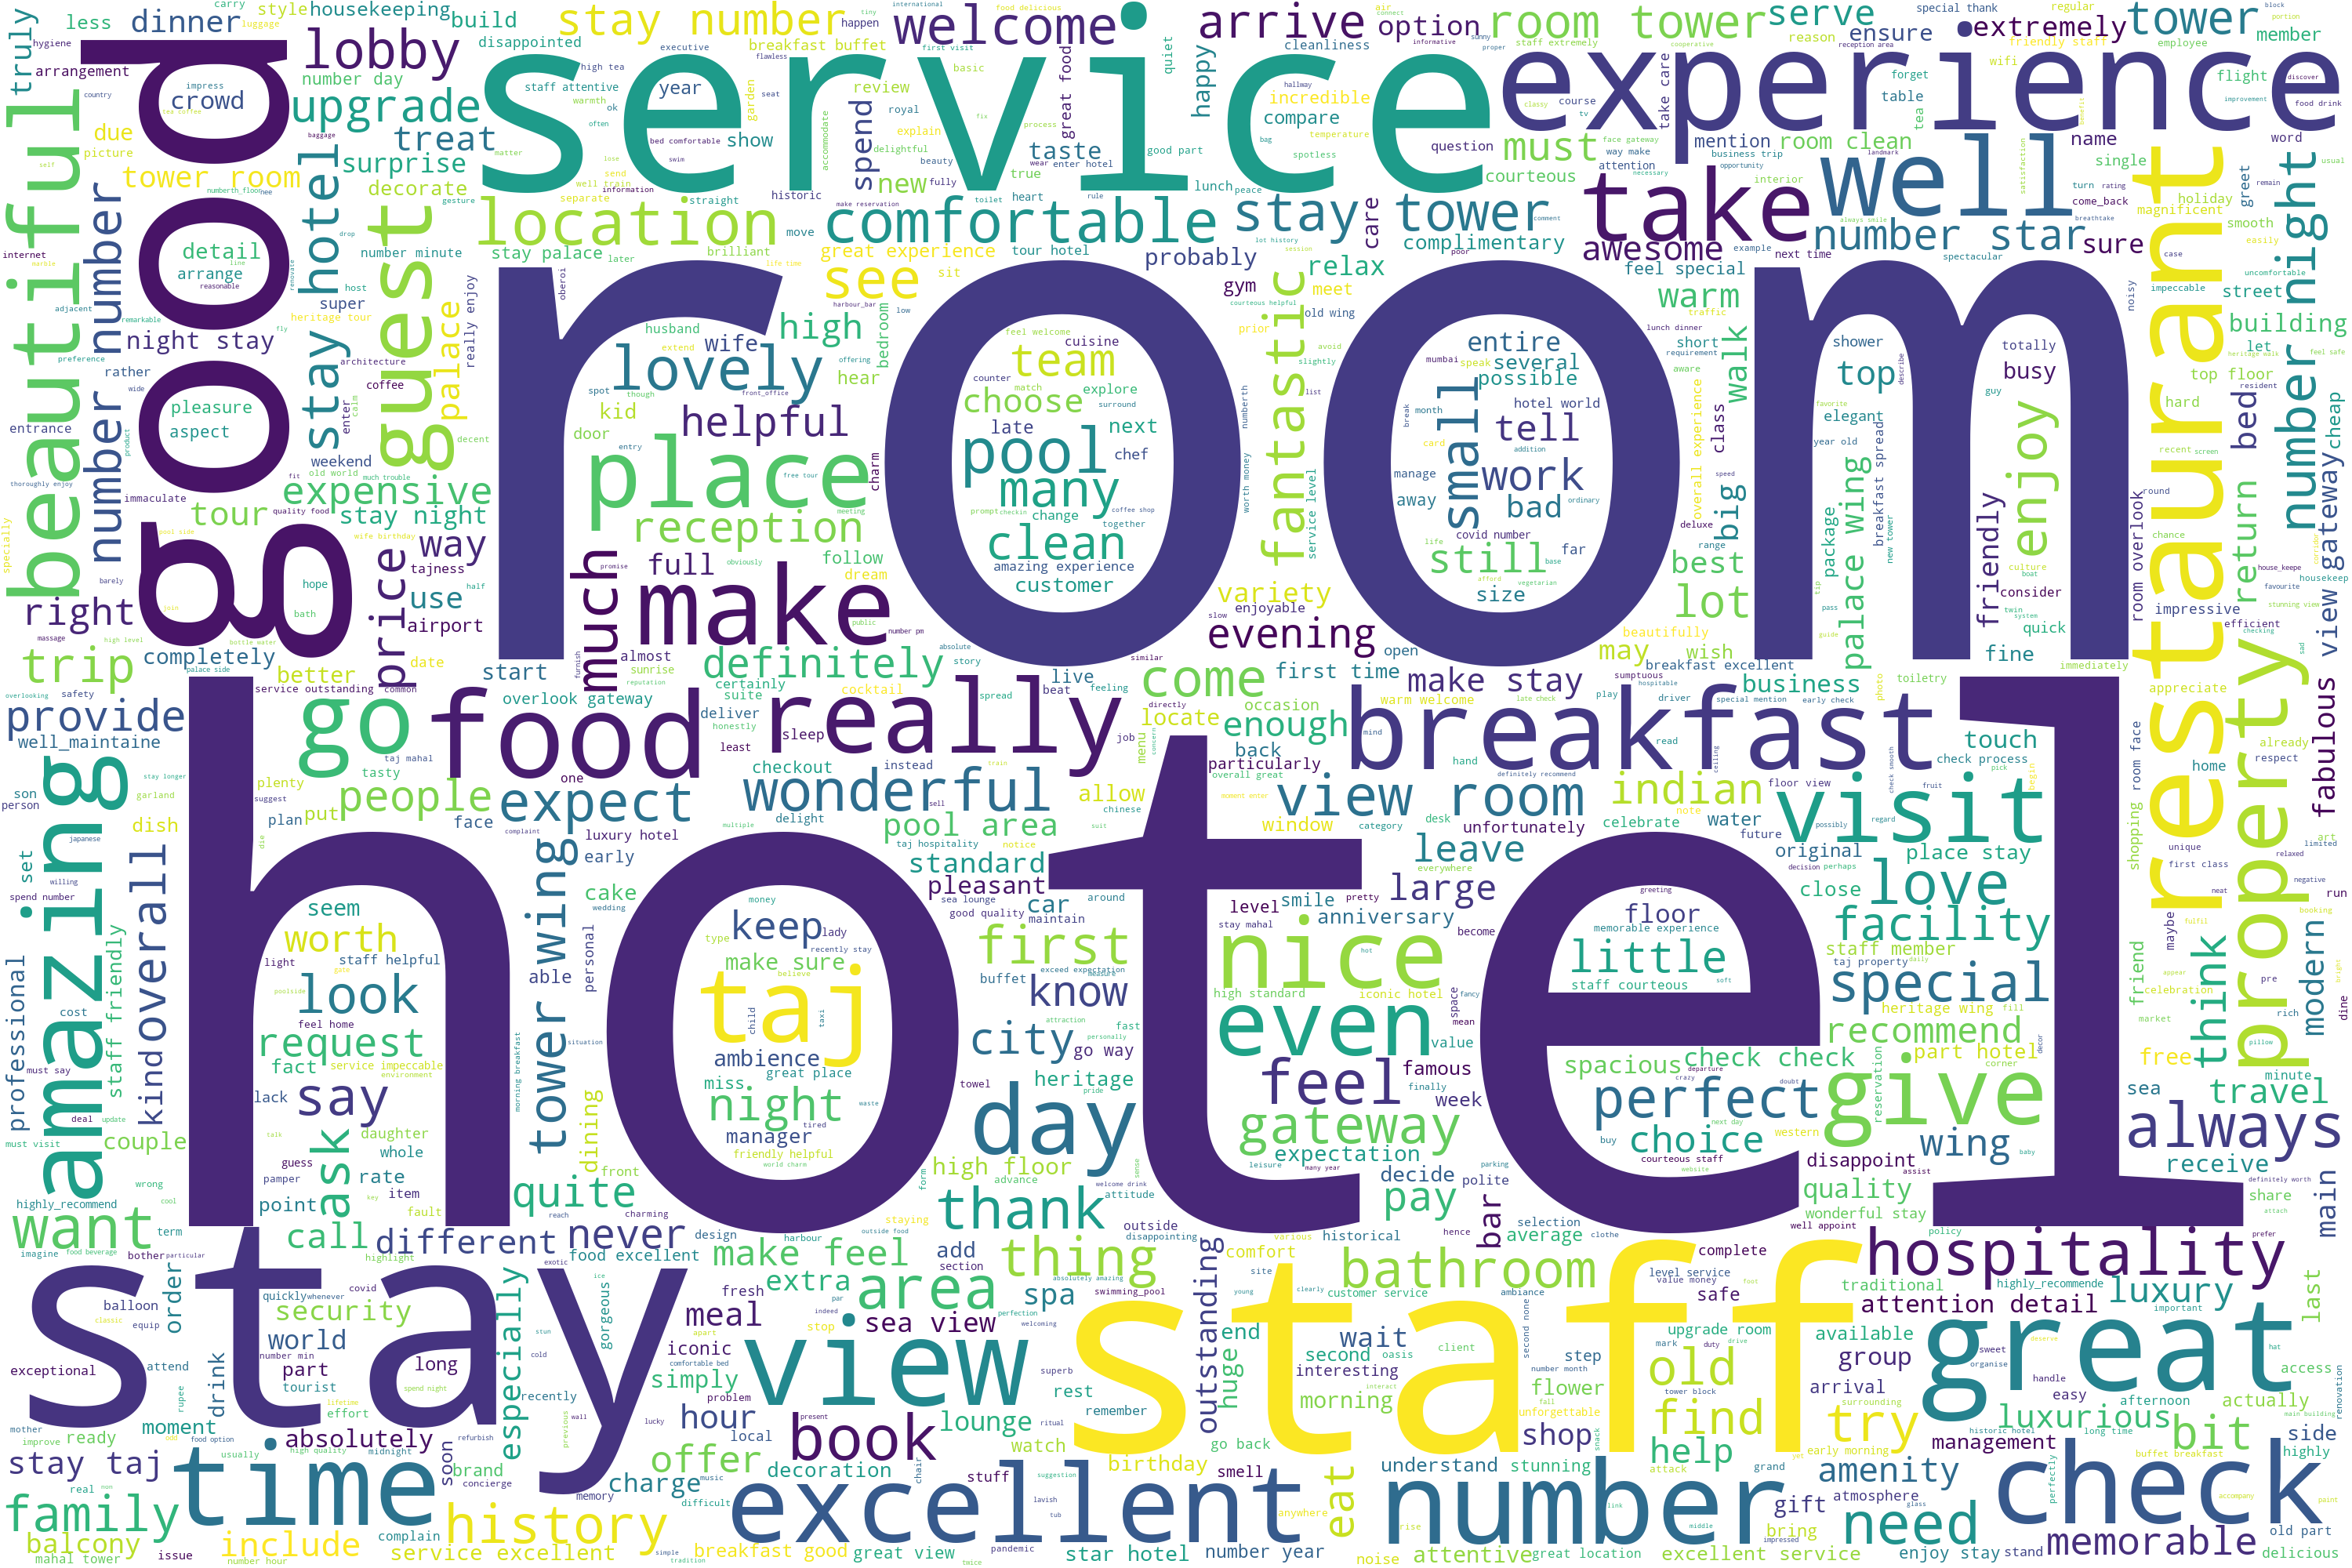

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=25, width = 3000, height = 2000,contour_color='steelblue')# Generate a word cloud

wordcloud.generate(wordlist)

# Visualize the word cloud
wordcloud.to_image()

### **Creating the Dictionary and Corpus needed for Topic Modeling**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the models.


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bad', 2),
  ('barely', 1),
  ('compare', 1),
  ('dishearten', 1),
  ('experience', 2),
  ('gold', 1),
  ('history', 1),
  ('hospitality', 1),
  ('hotel', 3),
  ('level', 2),
  ('loose', 1),
  ('make', 1),
  ('number', 3),
  ('say', 1),
  ('see', 1),
  ('sheen', 1),
  ('standard', 1),
  ('star', 3),
  ('top', 1),
  ('ultimate', 1)]]

## **Building the Topic Model**

## **LSI Model**

In [ ]:
from gensim import corpora, models
lsi_model = models.LsiModel(corpus=corpus, num_topics=10, id2word=id2word)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.480*"room" + 0.409*"hotel" + 0.363*"stay" + 0.267*"number" + 0.188*"staff" + 0.162*"good" + 0.160*"service" + 0.150*"view" + 0.137*"tower" + 0.112*"great"'),
 (1,
  '0.560*"number" + 0.507*"room" + -0.473*"hotel" + -0.258*"stay" + -0.117*"staff" + -0.101*"good" + -0.089*"great" + -0.079*"excellent" + -0.075*"experience" + -0.074*"make"'),
 (2,
  '-0.721*"number" + 0.566*"room" + -0.179*"hotel" + -0.151*"stay" + 0.113*"view" + -0.069*"experience" + -0.066*"make" + 0.060*"service" + -0.059*"star" + 0.059*"nice"'),
 (3,
  '-0.677*"hotel" + 0.487*"stay" + 0.197*"experience" + 0.177*"staff" + 0.151*"make" + 0.144*"taj" + -0.144*"room" + 0.114*"good" + 0.098*"check" + 0.094*"food"'),
 (4,
  '0.616*"stay" + -0.407*"good" + -0.267*"staff" + -0.237*"service" + -0.227*"experience" + -0.177*"food" + -0.175*"great" + 0.153*"tower" + 0.119*"wing" + -0.110*"restaurant"')]

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('Coherence Score: ', coherence_lsi)

Coherence Score:  0.4362060129230074


### **LDA Model**

We have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well. 

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the gensim docs, both defaults to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk.  `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### **Viewing the topics in LDA model**

The above LDA model is built with 5 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()` as shown below.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"number" + 0.018*"try" + 0.014*"star" + 0.014*"property" + '
  '0.014*"could" + 0.013*"indian" + 0.012*"new" + 0.012*"want" + 0.011*"sure" '
  '+ 0.010*"ask"'),
 (1,
  '0.016*"enter" + 0.014*"put" + 0.011*"pleasure" + 0.011*"greet" + '
  '0.009*"oasis" + 0.009*"stop" + 0.008*"weekend" + 0.008*"renovate" + '
  '0.008*"garden" + 0.008*"leave"'),
 (2,
  '0.047*"room" + 0.043*"hotel" + 0.040*"stay" + 0.019*"staff" + 0.019*"tower" '
  '+ 0.018*"good" + 0.018*"service" + 0.015*"view" + 0.013*"great" + '
  '0.012*"number"'),
 (3,
  '0.020*"number" + 0.016*"bathroom" + 0.016*"lobby" + 0.012*"eat" + '
  '0.011*"could" + 0.009*"back" + 0.009*"buffet" + 0.008*"choose" + '
  '0.008*"pay" + 0.007*"leave"'),
 (4,
  '0.041*"however" + 0.028*"year" + 0.016*"charge" + 0.014*"car" + '
  '0.014*"probably" + 0.013*"iconic" + 0.012*"busy" + 0.011*"let" + '
  '0.009*"short" + 0.009*"impressive"')]


### **Interpretation**

Topic 0 is a represented as - '0.037*"number" + 0.018*"try" + 0.014*"star" + 0.014*"property" + '
  '0.014*"could" + 0.013*"indian" + 0.012*"new" + 0.012*"want" + 0.011*"sure" '
  '+ 0.010*"ask"

It means the top 10 keywords that contribute to this topic are: 'number', 'try', 'star'.. and so on and the weight of 'number' on topic 0 is 0.037. 

The weights reflect how important a keyword is to that topic.

### **Computing Model Perplexity and Coherence Score**

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.910820996408901

Coherence Score:  0.4186227549212177


Here we have a coherence score of 0.556

### **Hyperparameter tuning**

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    best_parms = pd.DataFrame(model_results)
    pbar.close()


  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log

100%|██████████| 540/540 [1:15:15<00:00,  8.36s/it]


In [ ]:

sorted_df = best_parms.sort_values(["Coherence"], 
                                   ascending=False)
print(sorted_df)

    Validation_Set  Topics      Alpha       Beta  Coherence
263     75% Corpus      10  symmetric       0.91   0.594729
168     75% Corpus       7       0.91       0.91   0.583888
243     75% Corpus      10       0.01       0.91   0.578585
513    100% Corpus      10       0.01       0.91   0.577339
223     75% Corpus       9       0.61       0.91   0.569882
..             ...     ...        ...        ...        ...
31      75% Corpus       3       0.01       0.31   0.309872
34      75% Corpus       3       0.01  symmetric   0.309580
103     75% Corpus       5       0.61       0.91   0.307638
133     75% Corpus       6       0.61       0.91   0.305078
18      75% Corpus       2       0.91       0.91   0.303953

[540 rows x 5 columns]


### **Final Model**

In [ ]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta=0.91)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"cable" + 0.001*"permanently" + 0.001*"painter" + 0.001*"renovator" + '
  '0.001*"refrigeration" + 0.001*"repaint" + 0.001*"chiller" + 0.001*"beaning" '
  '+ 0.001*"bunch" + 0.001*"permanent"'),
 (1,
  '0.001*"custom" + 0.000*"warmth" + 0.000*"filtration" + 0.000*"organic" + '
  '0.000*"ayurvedic" + 0.000*"escape" + 0.000*"polluted" + 0.000*"smokey" + '
  '0.000*"pav" + 0.000*"medium"'),
 (2,
  '0.002*"fix" + 0.002*"paint" + 0.001*"handle" + 0.001*"request" + '
  '0.001*"raise" + 0.001*"promise" + 0.001*"later" + 0.001*"freshly" + '
  '0.001*"country" + 0.001*"session"'),
 (3,
  '0.001*"practical" + 0.001*"mechanical" + 0.001*"emotion" + '
  '0.001*"understanding" + 0.001*"form" + 0.001*"rule" + 0.000*"cool" + '
  '0.000*"system" + 0.000*"far" + 0.000*"thick"'),
 (4,
  '0.001*"effort" + 0.000*"message" + 0.000*"translation" + 0.000*"diverse" + '
  '0.000*"concerted" + 0.000*"fostering" + 0.000*"occasionally" + '
  '0.000*"sincerely" + 0.000*"morimoto" + 0.000*"minister"')

### **Visualizing the topics-keywords**

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.237038  0.000203       1        1  94.158566
2      0.031958  0.008985       2        1   2.317379
8      0.026195 -0.002892       3        1   0.684021
9      0.026442 -0.002427       4        1   0.508296
0      0.025774 -0.001308       5        1   0.413098
3      0.025131 -0.000146       6        1   0.402967
1      0.025140 -0.000053       7        1   0.392104
5      0.025349 -0.000398       8        1   0.390754
4      0.025420 -0.000511       9        1   0.386222
7      0.025630 -0.001453      10        1   0.346594, topic_info=              Term        Freq       Total Category  logprob  loglift
149           high   98.000000   98.000000  Default  30.0000  30.0000
711          could  111.000000  111.000000  Default  29.0000  29.0000
177      wonderful   94.000000   94.000000  Default  28.0000  28.0000
113           much  116.000000  116.000000  Default  27.0000  27.0000
181           even  106.000000  106.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
987   satisfaction    0.056001    6.076655  Topic10  -7.7124   0.9779
1324        switch    0.062653    8.869254  Topic10  -7.6001   0.7120
1676            tv    0.064973   12.256329  Topic10  -7.5638   0.4249
1214       culture    0.057502   12.747228  Topic10  -7.6859   0.2635
1230       happily    0.051172    6.011958  Topic10  -7.8026   0.8984

[457 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3569      1  0.780372  acceptable
1336      1  0.891564  accessible
2247      1  0.488552      active
2247      2  0.488552      active
2576      1  0.811410      advise
...     ...       ...         ...
1325      1  0.851073      yellow
2665      1  0.492437   yesterday
2665      2  0.492437   yesterday
1660      1  0.735998        yoga
1660      2  0.245333        yoga

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 9, 10, 1, 4, 2, 6, 5, 8])

### **Interpretation of pyLDAvis’s output**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

If we move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## **LDA Mallet Model**

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('view', 0.12313895781637717),
   ('stay', 0.07847394540942929),
   ('night', 0.05893300248138958),
   ('room', 0.05676178660049628),
   ('wing', 0.056451612903225805),
   ('tower', 0.04652605459057072),
   ('gateway', 0.04218362282878412),
   ('palace', 0.033498759305210915),
   ('floor', 0.028846153846153848),
   ('upgrade', 0.024193548387096774)]),
 (1,
  [('make', 0.09430318635339556),
   ('experience', 0.08947537817830704),
   ('taj', 0.07016414547795301),
   ('hospitality', 0.03894431927904731),
   ('special', 0.03765690376569038),
   ('love', 0.027679433537174124),
   ('visit', 0.026392018023817188),
   ('perfect', 0.023173479240424847),
   ('family', 0.019954940457032506),
   ('team', 0.019633086578693275)]),
 (2,
  [('service', 0.1652264085724162),
   ('stay', 0.08987210508123056),
   ('excellent', 0.0850328378845489),
   ('property', 0.042170756999654335),
   ('wonderful', 0.03560318008987211),
   ('beautiful', 0.02523332181126858),
   ('expect', 0.023850674040788108)

### **Finding the optimal number of topics for LDA**

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The `compute_coherence_values()` trains multiple LDA models and provides the models and their corresponding coherence scores.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

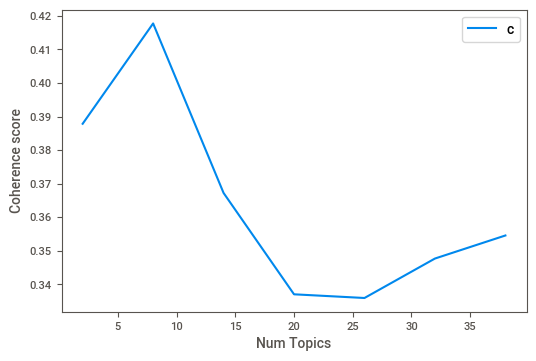

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3878
Num Topics = 8  has Coherence Value of 0.4177
Num Topics = 14  has Coherence Value of 0.3672
Num Topics = 20  has Coherence Value of 0.337
Num Topics = 26  has Coherence Value of 0.3359
Num Topics = 32  has Coherence Value of 0.3477
Num Topics = 38  has Coherence Value of 0.3545


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [ ]:
model_list[1]

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.092*"experience" + 0.056*"taj" + 0.050*"feel" + 0.043*"amazing" + '
  '0.031*"property" + 0.027*"love" + 0.022*"special" + 0.020*"perfect" + '
  '0.018*"staff" + 0.017*"place"'),
 (1,
  '0.137*"staff" + 0.076*"make" + 0.042*"service" + 0.038*"visit" + '
  '0.032*"hospitality" + 0.032*"guest" + 0.022*"helpful" + 0.017*"family" + '
  '0.016*"recommend" + 0.015*"detail"'),
 (2,
  '0.153*"number" + 0.071*"check" + 0.060*"time" + 0.029*"book" + 0.023*"room" '
  '+ 0.020*"upgrade" + 0.019*"thing" + 0.014*"star" + 0.013*"pay" + '
  '0.013*"request"'),
 (3,
  '0.167*"hotel" + 0.041*"pool" + 0.036*"area" + 0.033*"beautiful" + '
  '0.033*"nice" + 0.032*"location" + 0.027*"place" + 0.024*"lovely" + '
  '0.020*"tour" + 0.019*"history"'),
 (4,
  '0.128*"good" + 0.088*"great" + 0.073*"food" + 0.068*"breakfast" + '
  '0.064*"restaurant" + 0.061*"excellent" + 0.021*"clean" + 0.015*"find" + '
  '0.015*"quality" + 0.015*"facility"'),
 (5,
  '0.201*"stay" + 0.087*"service" + 0.052*"night" + 0.0

Those were the topics for the chosen LDA model.

### **Finding the dominant topic in each sentence**

One of the practical application of topic modeling is to determine what topic a given document is about.
To find that, we find the topic number that has the highest percentage contribution in that document.


The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['review'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...   taj should relook and compare yourself with y...
1            1  ...   every time i stay here i feel welcomes and lo...
2            2  ...   custom porridge was provided to the baby brea...
3            3  ...   allocated the numbernd room number which was ...
4            4  ...   amazing experience if you are visiting mumbai...
5            5  ...   taj should relook and compare yourself with y...
6            6  ...   every time i stay here i feel welcomes and lo...
7            7  ...   custom porridge was provided to the baby brea...
8            8  ...   allocated the numbernd room number which was ...
9            9  ...   amazing experience if you are visiting mumbai...

[10 rows x 5 columns]

### **Finding the most representative document for each topic**

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.



In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  ...                                               Text
0        0.0  ...   custom porridge was provided to the baby brea...
1        1.0  ...   in my travels around the world i have never e...
2        2.0  ...   the hospitality was missing and most of the s...
3        3.0  ...   had a wonderful three night stay at this hote...
4        4.0  ...   the overall stay was great few things to call...

[5 rows x 4 columns]

The tabular output above had 5 rows, one each for a topic. It has the topic number, the keywords and the most representative document. The `Perc_Contribution` column is nothing but the percentage contribution of the topic in the given document.

### **Topic distribution across documents**

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

Dominant_Topic  ... Perc_Documents
0.0             2.0  ...         0.1693
1.0             0.0  ...         0.1393
2.0             0.0  ...         0.1022
3.0             6.0  ...         0.1353
4.0             1.0  ...         0.1323

[5 rows x 4 columns]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Conclusion</h2>
</div>




